In [68]:
import os
import pandas as pd 
import numpy as np
import glob 
import itertools
import upsetplot
from matplotlib import pyplot as plt
from qmplot import manhattanplot
os.chdir('/mnt/BioHome/jreyna/jreyna/projects/dchallenge')

outdir = 'results/main/gwas/summary/'
os.makedirs(outdir, exist_ok=True)

In [69]:
gwas_samplesheet = pd.read_table('config/gwas_samplesheets/gwas.samplesheet.tsv')

In [70]:
gwas_samplesheet.set_index('gwas_id', inplace=True)

## Loading Significant GWASes 

In [71]:
gwas_sss = 'results/main/2021_Nikhil_eQTL/Data/T1D_GWAS/*/GRCh38/GWAS_input_colocalization_pval_lt_5eMinus8.txt'
gwas_sss = glob.glob(gwas_sss)
gwas_sss

['results/main/2021_Nikhil_eQTL/Data/T1D_GWAS/T1D_25751624/GRCh38/GWAS_input_colocalization_pval_lt_5eMinus8.txt',
 'results/main/2021_Nikhil_eQTL/Data/T1D_GWAS/T1D_34594039_GCST90018705/GRCh38/GWAS_input_colocalization_pval_lt_5eMinus8.txt',
 'results/main/2021_Nikhil_eQTL/Data/T1D_GWAS/T1D_34012112_Gaulton/GRCh38/GWAS_input_colocalization_pval_lt_5eMinus8.txt',
 'results/main/2021_Nikhil_eQTL/Data/T1D_GWAS/T1D_32005708/GRCh38/GWAS_input_colocalization_pval_lt_5eMinus8.txt',
 'results/main/2021_Nikhil_eQTL/Data/T1D_GWAS/T1D_34594039_GCST90018925/GRCh38/GWAS_input_colocalization_pval_lt_5eMinus8.txt']

In [72]:
data = []
for fn in gwas_sss:
    gwas_source = fn.split('/')[5]
    
    if gwas_source in gwas_samplesheet.index.tolist():
        df = pd.read_table(fn, sep= ' ')
        df['gwas_source'] = gwas_source
        data.append(df)

In [73]:
gwas_data = pd.concat(data)

# adding a variant ID for downstream analyses
gwas_data['var_id'] = gwas_data['CHR'].str.replace('chr', '') + ':' + gwas_data['POS'].astype(str)

## Number of GWAS Variants by Study

In [106]:
gwas_grps = gwas_data.groupby(['gwas_source'])
study_summary = gwas_grps['var_id'].nunique().to_frame()
study_summary.columns = ['num_vars']
study_summary = study_summary.merge(gwas_samplesheet[['authorship']],
                    left_on='gwas_source', right_index=True)

In [107]:
# make the final summary table
final_df = study_summary[['authorship', 'num_vars']]
final_df.columns = ['GWAS Source', 'Number of Sig. GWAS']
final_df

,GWAS Source,Number of Sig. GWAS
gwas_source,,
T1D_25751624,"Onengut-Gumuscu et al., 2015",1722
T1D_32005708,"Forgetta et al., 2020",21097
T1D_34012112_Gaulton,"Chiou et al., 2021",45798
T1D_34594039_GCST90018925,"Sakaue et al., 2021",20419


In [112]:
final_df.iloc[:, 1].tolist()

[1722, 21097, 45798, 20419]

## Making an upset plot of overlaps

https://github.com/ShujiaHuang/qmplot

In [124]:
# converting from dataframe groups to dict format 
var_members = {}
for gwas_source, gwas_df in gwas_grps:
    authorship = gwas_samplesheet.loc[gwas_source, 'authorship']
    var_members[authorship] = gwas_df.var_id.unique().tolist()
    print(len(var_members[authorship]))

1722
21097
45798
20419


In [125]:
# making the upset input dataframe
upset_input = upsetplot.from_contents(var_members)

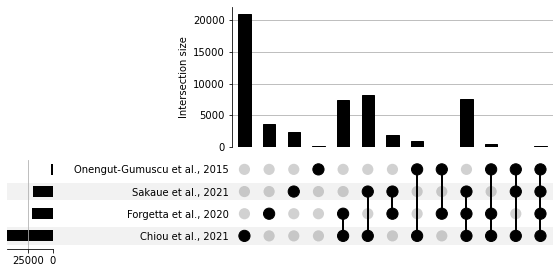

In [103]:
# plotting the upset plot
plt = upsetplot.UpSet(upset_input, subset_size='count').plot()

#### Getting some details

In [153]:
count_chiou = upset_input.loc[(upset_input.index.get_level_values(2) == True)]

In [154]:
count_chiou.shape

(45798, 1)

In [155]:
count_chiou = upset_input.loc[(upset_input.index.get_level_values(0) == False) & 
                (upset_input.index.get_level_values(1) == False) & 
                (upset_input.index.get_level_values(2) == True) & 
                (upset_input.index.get_level_values(3) == False)]

In [156]:
count_chiou.shape

(20981, 1)

In [157]:
count_shared = upset_input.loc[(upset_input.index.get_level_values(0) == True) & 
                (upset_input.index.get_level_values(1) == True) & 
                (upset_input.index.get_level_values(2) == True) & 
                (upset_input.index.get_level_values(3) == True)]

In [158]:
count_shared.shape

(191, 1)

In [164]:
count_wgs = upset_input.loc[(upset_input.index.get_level_values(0) == False) & 
                (upset_input.index.get_level_values(1) == True) & 
                (upset_input.index.get_level_values(2) == True) & 
                (upset_input.index.get_level_values(3) == True)]

In [165]:
count_wgs.shape

(7593, 1)

## Making a GWAS Plot For Each (Filtered) Dataset 

https://upsetplot.readthedocs.io/en/stable/formats.html

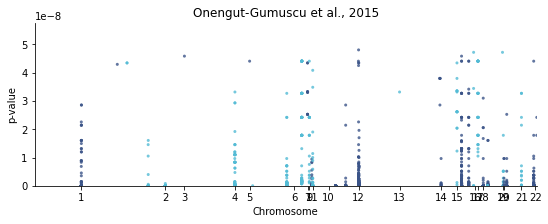

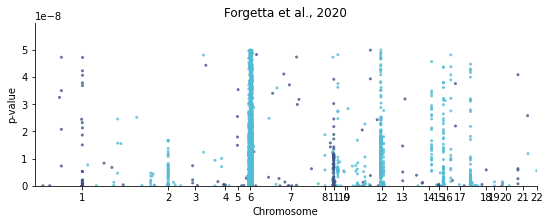

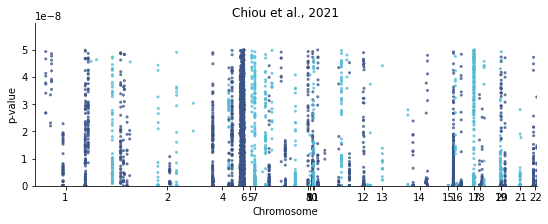

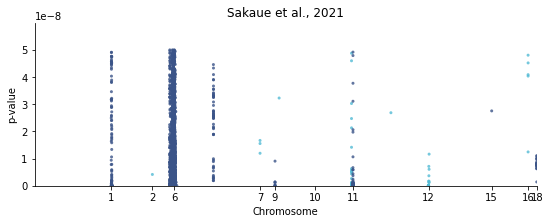

In [79]:
# generate manhattan plot and set an output file.
i = 0
for gwas_source, gwas_df in gwas_grps:
    
    title = gwas_samplesheet.loc[gwas_source, 'authorship']
    
    # remove chr for plotting purposes
    plot_df = gwas_df.copy()
    plot_df.loc[:, 'CHR'] = plot_df['CHR'].str.replace('chr', '').astype(int)
    plot_df.sort_values('CHR', inplace=True)
        
    # plot and save
    outfn = os.path.join(outdir, '{}.png'.format(gwas_source))
    manhattanplot(data=plot_df,
                       chrom='CHR',
                       pos='POS',
                       pv='P', 
                       title = title, 
                       ylabel='p-value',
                       suggestiveline=None,
                       genomewideline=None,
                       is_show=True,
                       figname=outfn,
                       logp=False)
    i += 1 
    

## Loading GWAS Plots For Each (Un-Filtered) Dataset 

These plots were made using:

    1) workflow/scripts/gwas/convert_gwas_catalog_to_plink.sh
    2) workflow/scripts/gwas/plot_manhattan_plot.py
    
Still not complete. Need to convert from the GWAS Catalog format and into the Plink Format (step 1).

In [80]:
from IPython.display import Image, display
from IPython.core.display import HTML 

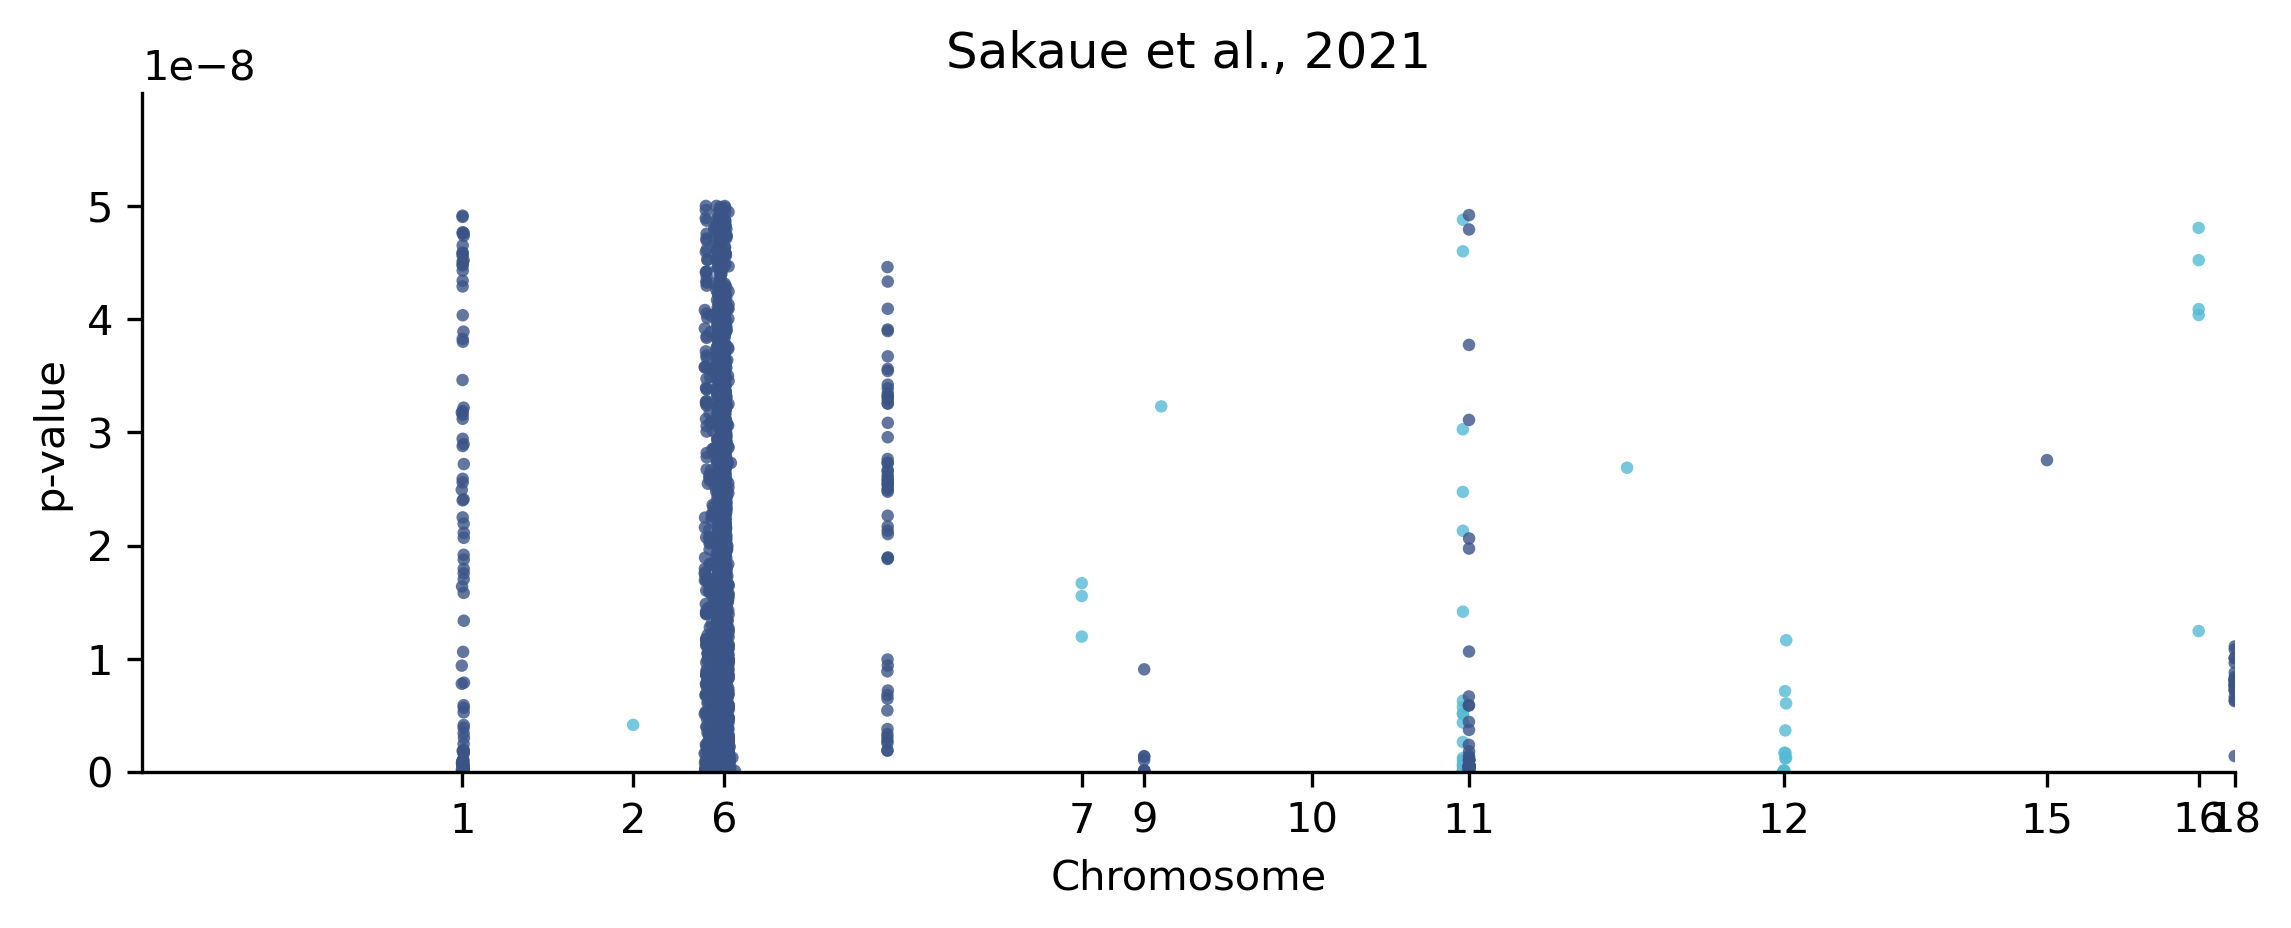

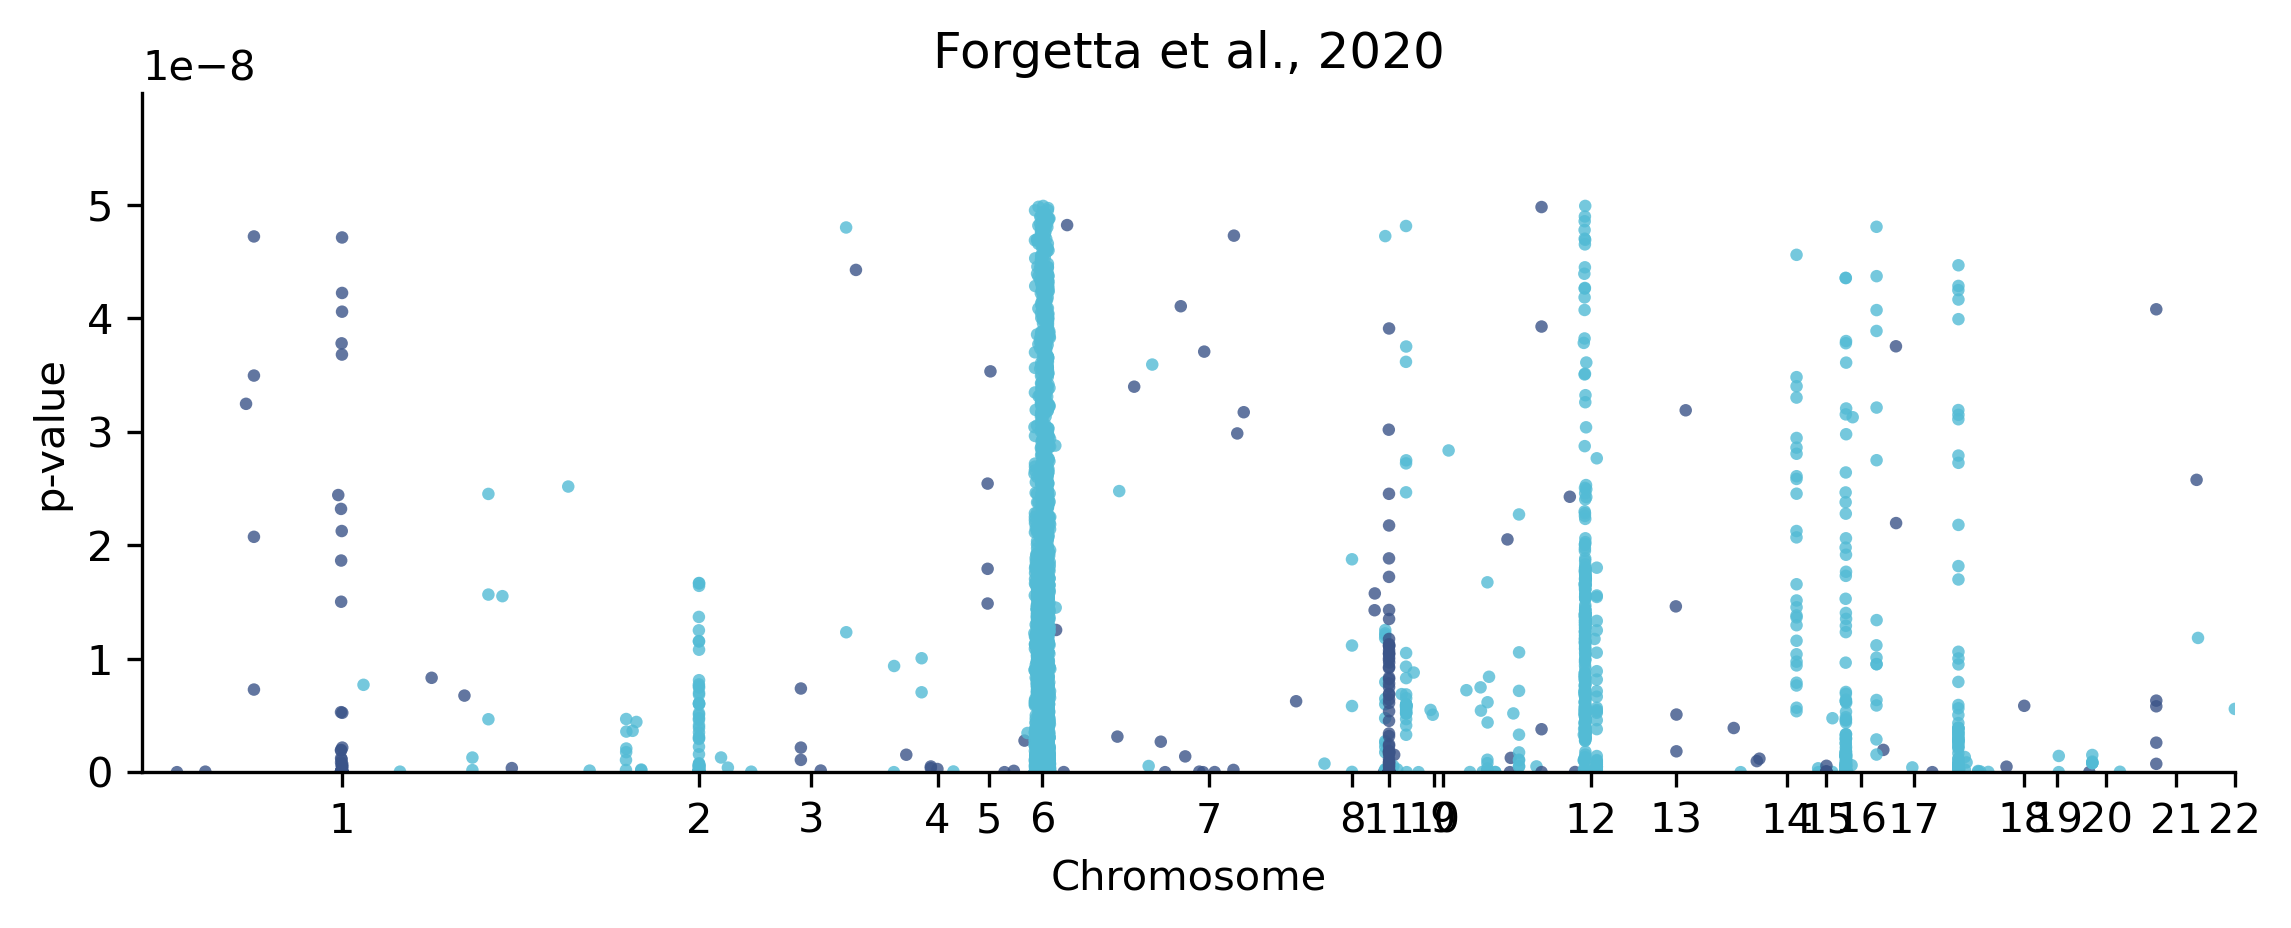

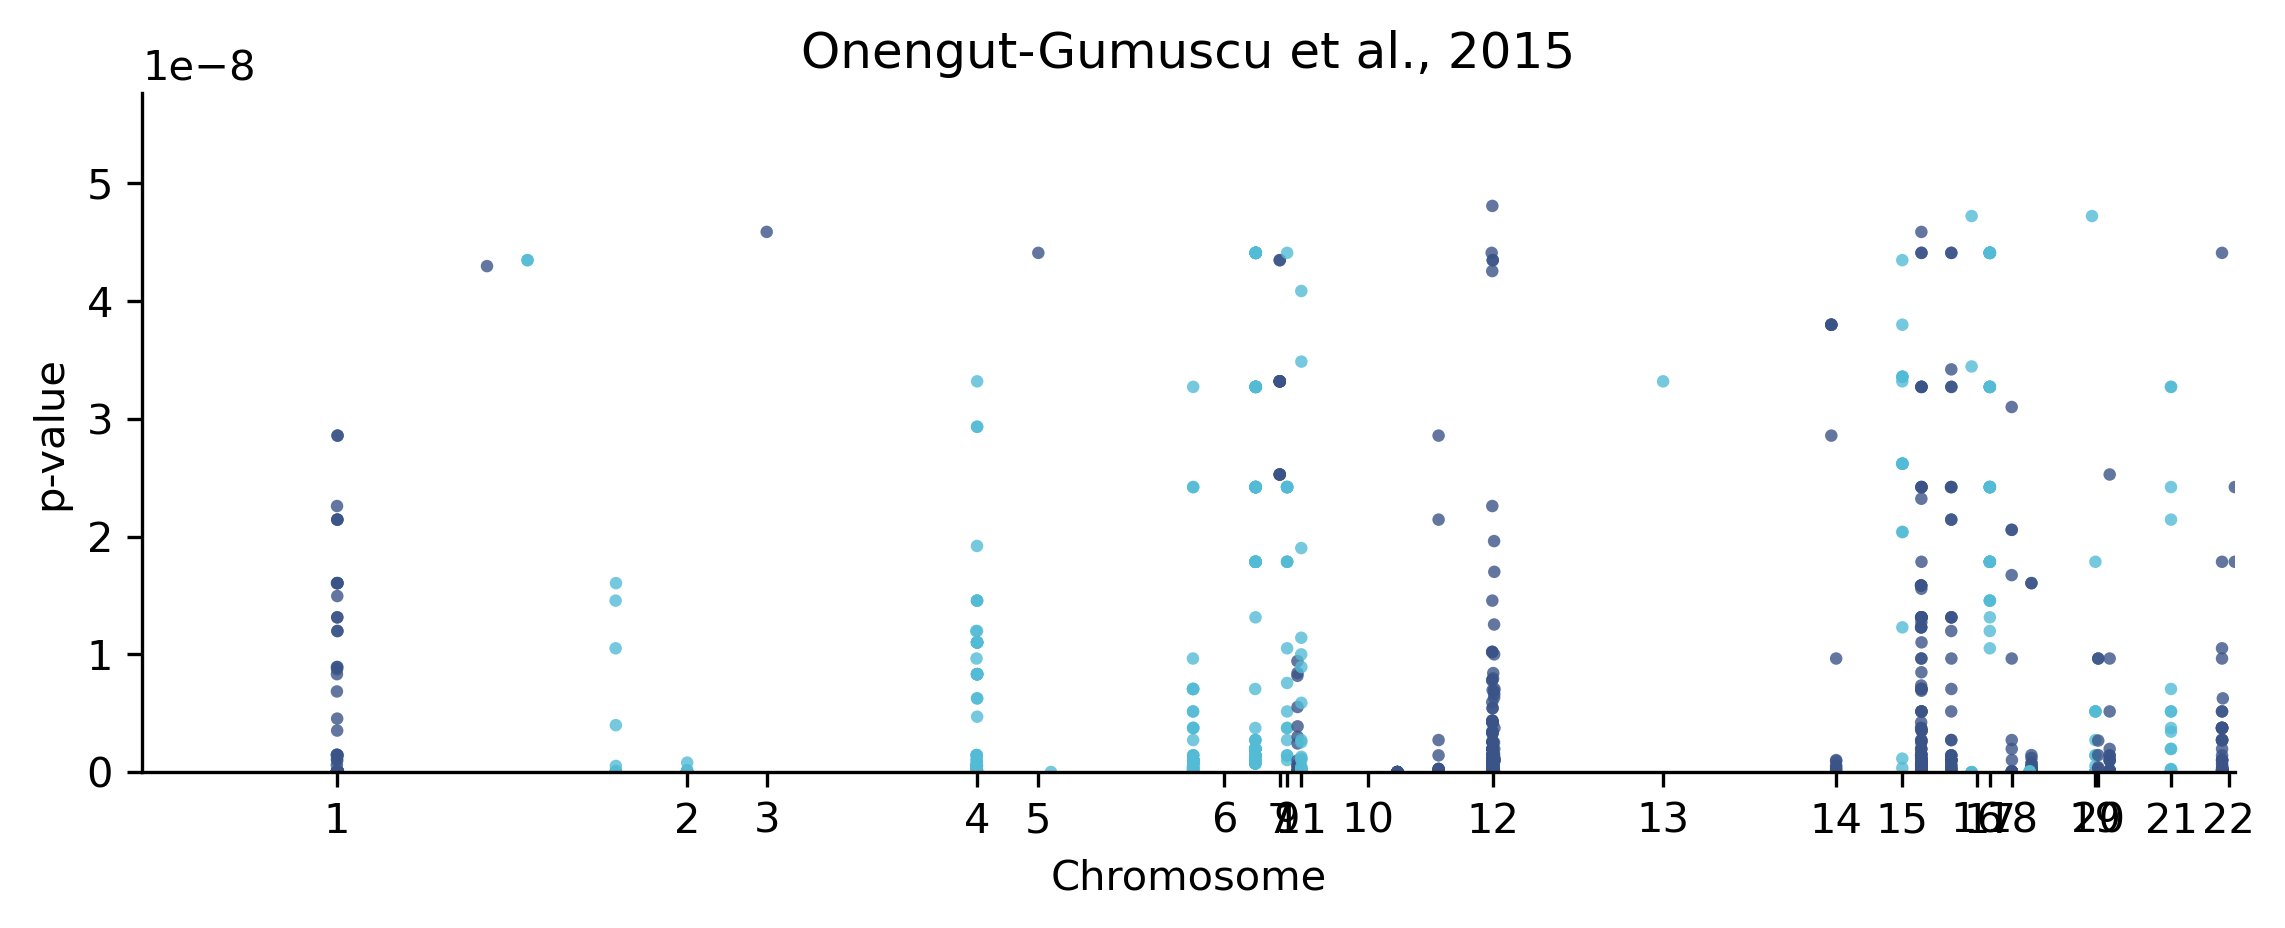

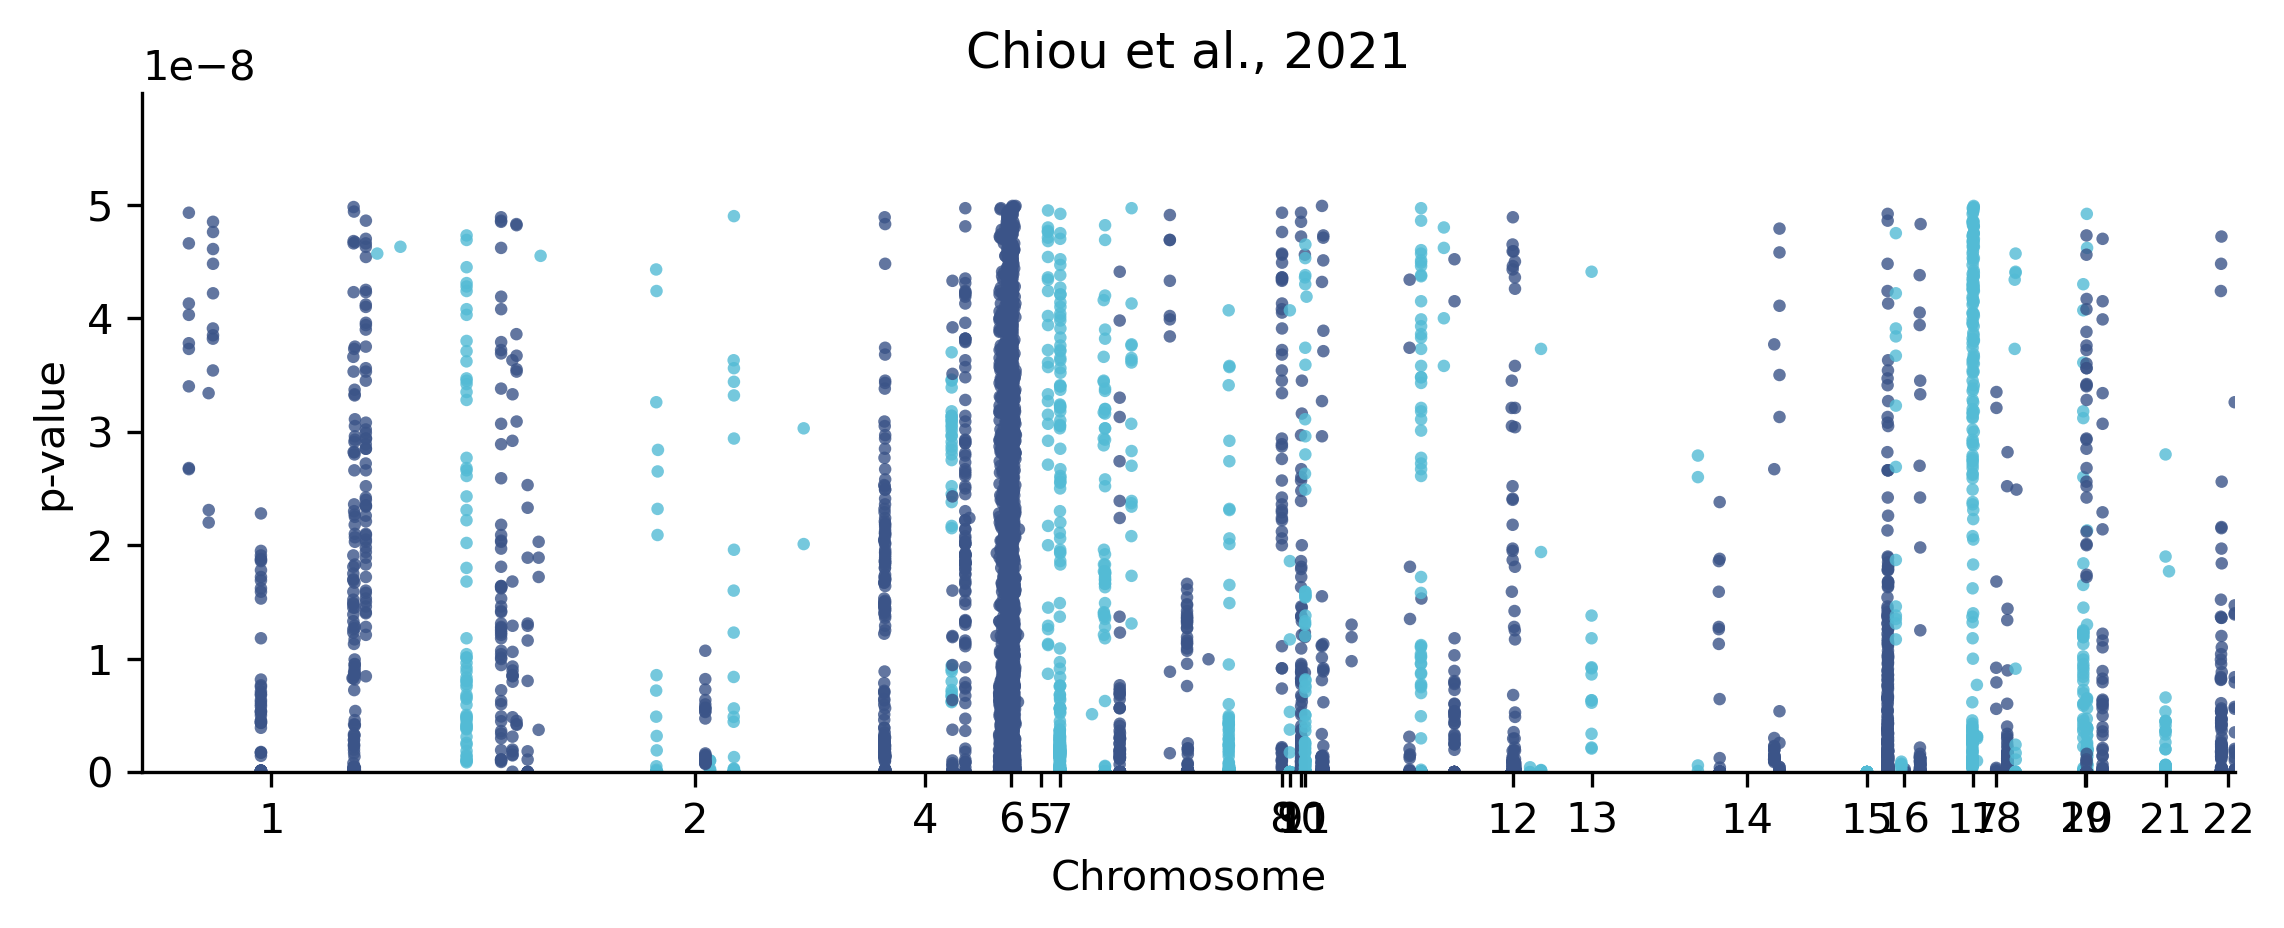

In [81]:
for fn in glob.glob('results/main/gwas/summary/*.png'):
    display(Image(data=fn, width=500, height=400))